In [177]:
# Importar bibliotecas necessárias
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk


## Pré-processamento

### Lendo o arquivo

In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Ler o arquivo CSV
df = pd.read_csv("data.csv", names=['data', 'label'])

### Removendo linhas com valores nulos ou vazios

In [179]:
# Remover linhas com valores nulos ou vazios
df = df.dropna()

### Removendo a primeira linha

In [180]:
# Remover a primeira linha
df = df.iloc[1:]


### Removendo alphanumericos, pontuação, stopwords e deixando tudo em minúsculo

In [181]:
nltk.download('stopwords')
# Remover alfanuméricos
df['data'] = df['data'].str.replace('\d+', '')

# Deixar tudo em minúsculo
df['data'] = df['data'].str.lower()

# Remover pontuação
df['data'] = df['data'].str.replace('[^\w\s]', '')

# Remover stopwords
stopwords = nltk.corpus.stopwords.words('english')
df['data'] = df['data'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwords))

[nltk_data] Downloading package stopwords to /home/apo-pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_11864/2354185342.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['data'] = df['data'].str.replace('\d+', '')
/tmp/ipykernel_11864/2354185342.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['data'] = df['data'].str.replace('[^\w\s]', '')


### Lemmatização

In [182]:
# Lemmatização
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
df['data'] = df['data'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to /home/apo-pc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Dividindo os dados em treino e teste

In [183]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['label'], test_size=0.2, random_state=42)

In [184]:
# COntar qtd de classes
y_train.value_counts()


neutral     2508
positive    1480
negative     685
Name: label, dtype: int64

### Codificando a variável target

In [185]:
# Instantiate the label encoder
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train = label_encoder.fit_transform(y_train)

# Transform the test labels (use the same label encoder instance)
y_test = label_encoder.transform(y_test)

## Vetorização
### TF-IDF

In [186]:
# Pré-processar os dados de texto
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



X_puro_train_tfidf = X_train_tfidf
X_puro_test_tfidf = X_test_tfidf

## Treinamento
### Importando bibliotecas
(Pytorch=LSTM, RNN, CNN)

In [187]:
# Importar bibliotecas necessárias
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

#

### LSTM

In [171]:
# Importing necessary PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Definindo dispositivo CUDA

In [172]:
print(f"CUDA é suportado pelo sistema? {torch.cuda.is_available()}")
print(f"Versao do CUDA: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID do CUDA device: {torch.cuda.current_device()}")
       
print(f"Nome do dispositivo CUDA:{torch.cuda.get_device_name(cuda_id)}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_default_device('cuda')


CUDA é suportado pelo sistema? True
Versao do CUDA: 12.1
ID do CUDA device: 0
Nome do dispositivo CUDA:NVIDIA GeForce RTX 4060


In [173]:
# Convert text data to PyTorch tensors
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train_tfidf, y_train)
test_dataset = TensorDataset(X_test_tfidf, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
# Define a simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Add an extra dimension to the input tensor
        x = x.unsqueeze(1)

        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Set hyperparameters
input_size = X_train_tfidf.shape[1]
hidden_size = 64
num_layers = 1
output_size = len(df['label'].unique())  # Assuming your labels are numerical

# Instantiate the model, loss function, and optimizer
model = SimpleLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the LSTM model
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tfidf)
    _, predicted = torch.max(test_outputs, 1)

In [54]:
# Convert the PyTorch tensors back to NumPy arrays for sklearn metrics
predicted = predicted.cpu().numpy()
y_test = y_test.cpu().numpy()

# Print classification report and accuracy
print("Classification Report:\n", classification_report(y_test, predicted))
print("Accuracy:", accuracy_score(y_test, predicted))

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.25      0.27       175
           1       0.71      0.76      0.74       622
           2       0.73      0.71      0.72       372

    accuracy                           0.67      1169
   macro avg       0.58      0.57      0.58      1169
weighted avg       0.66      0.67      0.66      1169

Accuracy: 0.6680923866552609


#### Avaliando o modelo

In [59]:
class RobustLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True, dropout=0.5):
        super(RobustLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

# Set hyperparameters
input_size = X_train_tfidf.shape[1]
hidden_size = 64
num_layers = 2  # Increased the number of layers
output_size = len(df['label'].unique())
bidirectional = True
dropout = 0.5

# Instantiate the model with bidirectional LSTM and dropout
model = RobustLSTM(input_size, hidden_size, num_layers, output_size, bidirectional=bidirectional, dropout=dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Implement learning rate scheduling
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Train the LSTM model with progress updates
num_epochs = 10
print_interval = 100  # Print loss every 100 batches

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print training progress
        if batch_idx % print_interval == 0 and batch_idx > 0:
            avg_loss = total_loss / print_interval
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            total_loss = 0.0

    # Learning rate scheduling step
    scheduler.step()

Epoch [1/10], Batch [100/147], Loss: 1.0027
Epoch [2/10], Batch [100/147], Loss: 0.8041
Epoch [3/10], Batch [100/147], Loss: 0.5553
Epoch [4/10], Batch [100/147], Loss: 0.3283
Epoch [5/10], Batch [100/147], Loss: 0.2272
Epoch [6/10], Batch [100/147], Loss: 0.1786
Epoch [7/10], Batch [100/147], Loss: 0.1722
Epoch [8/10], Batch [100/147], Loss: 0.1692
Epoch [9/10], Batch [100/147], Loss: 0.1654
Epoch [10/10], Batch [100/147], Loss: 0.1639


In [60]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tfidf)
    _, predicted = torch.max(test_outputs, 1)

# Convert the PyTorch tensors back to NumPy arrays for sklearn metrics
predicted = predicted.cpu().numpy()
# y_test = y_test.numpy()

# Print classification report and accuracy
print("Classification Report:\n", classification_report(y_test, predicted))
print("Accuracy:", accuracy_score(y_test, predicted))

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.26      0.29       175
           1       0.72      0.77      0.74       622
           2       0.73      0.70      0.72       372

    accuracy                           0.67      1169
   macro avg       0.59      0.58      0.58      1169
weighted avg       0.66      0.67      0.67      1169

Accuracy: 0.6740804106073567


In [63]:
from sklearn.model_selection import ParameterGrid

# Define a grid of hyperparameters to search
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'bidirectional': [True, False],
    'dropout': [0.3, 0.5, 0.7],
    'learning_rate': [0.001, 0.01, 0.1],
}

best_accuracy = 0.0
best_params = None

# Perform grid search
for params in ParameterGrid(param_grid):
    model = RobustLSTM(input_size, params['hidden_size'], params['num_layers'],
                       output_size, bidirectional=params['bidirectional'], dropout=params['dropout'])
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        scheduler.step()

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tfidf)
        _, predicted = torch.max(test_outputs, 1)

    accuracy = accuracy_score(y_test, predicted.cpu())
    print(f"Parameters: {params}, Accuracy: {accuracy:.4f}")

    # Update best parameters if the current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Parameters: {'bidirectional': True, 'dropout': 0.3, 'hidden_size': 32, 'learning_rate': 0.001, 'num_layers': 1}, Accuracy: 0.7066
Parameters: {'bidirectional': True, 'dropout': 0.3, 'hidden_size': 32, 'learning_rate': 0.001, 'num_layers': 2}, Accuracy: 0.6775
Parameters: {'bidirectional': True, 'dropout': 0.3, 'hidden_size': 32, 'learning_rate': 0.001, 'num_layers': 3}, Accuracy: 0.6561
Parameters: {'bidirectional': True, 'dropout': 0.3, 'hidden_size': 32, 'learning_rate': 0.01, 'num_layers': 1}, Accuracy: 0.6655
Parameters: {'bidirectional': True, 'dropout': 0.3, 'hidden_size': 32, 'learning_rate': 0.01, 'num_layers': 2}, Accuracy: 0.6689
Parameters: {'bidirectional': True, 'dropout': 0.3, 'hidden_size': 32, 'learning_rate': 0.01, 'num_layers': 3}, Accuracy: 0.6843
Parameters: {'bidirectional': True, 'dropout': 0.3, 'hidden_size': 32, 'learning_rate': 0.1, 'num_layers': 1}, Accuracy: 0.6715
Parameters: {'bidirectional': True, 'dropout': 0.3, 'hidden_size': 32, 'learning_rate': 0.1, 'n

## RNN

In [119]:
# Convert text data to PyTorch tensors
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train_tfidf, y_train)
test_dataset = TensorDataset(X_test_tfidf, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

AttributeError: 'Tensor' object has no attribute 'toarray'

In [121]:

# Define a simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Set hyperparameters
input_size = X_train_tfidf.shape[1]
hidden_size = 64
num_layers = 1
output_size = len(torch.unique(y_train))

# Instantiate the model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [122]:

# Set hyperparameters
input_size = X_train_tfidf.shape[1]
hidden_size = 64
num_layers = 1
output_size = len(torch.unique(y_train))

# Instantiate the model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the RNN model
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Add a sequence dimension to the input
        inputs = inputs.unsqueeze(1)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))


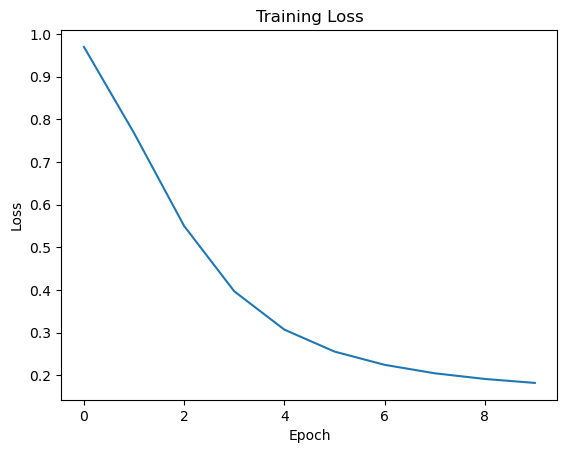

Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.24      0.27       175
           1       0.71      0.76      0.73       622
           2       0.72      0.72      0.72       372

    accuracy                           0.67      1169
   macro avg       0.58      0.57      0.57      1169
weighted avg       0.65      0.67      0.66      1169

Accuracy: 0.6672369546621043


In [123]:
import matplotlib.pyplot as plt

# Plot the loss graph
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    # Add a sequence dimension to the test input
    X_test_tfidf = X_test_tfidf.unsqueeze(1)
    X_test_tfidf = X_test_tfidf

    test_outputs = model(X_test_tfidf)
    _, predicted = torch.max(test_outputs, 1)


# Convert the PyTorch tensors back to NumPy arrays for sklearn metrics
predicted = predicted.cpu().numpy()
y_test = y_test.cpu().numpy()

# Print classification report and accuracy
print("Classification Report:\n", classification_report(y_test, predicted))
print("Accuracy:", accuracy_score(y_test, predicted))

## RNN mais Robusto com GridSearch


In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Assuming you have X_train_tfidf, X_test_tfidf, y_train, and y_test from your previous code

# # Convert text data to PyTorch tensors
# X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
# X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.long)
# y_test = torch.tensor(y_test, dtype=torch.long)

# # Create DataLoader for training and testing data
# train_dataset = TensorDataset(X_train_tfidf, y_train)
# test_dataset = TensorDataset(X_test_tfidf, y_test)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a more robust RNN model
class RobustRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.0):
        super(RobustRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

In [128]:
# Create a function to train and # Convert text data to PyTorch tensors
# X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
# X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.long)
# y_test = torch.tensor(y_test, dtype=torch.long)

# # Create DataLoader for training and testing data
# train_dataset = TensorDataset(X_train_tfidf, y_train)
# test_dataset = TensorDataset(X_test_tfidf, y_test)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)evaluate the model
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loss
        model.eval()
        with torch.no_grad():
            epoch_val_loss = 0.0
            for val_inputs, val_labels in test_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                epoch_val_loss += val_loss.item()

            val_losses.append(epoch_val_loss / len(test_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    return train_losses, val_losses

# Set hyperparameters for grid search
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'dropout_rate': [0.0, 0.1, 0.2],
}

# Instantiate the model, loss function, and optimizer
base_model = RobustRNN(input_size, hidden_size, num_layers, output_size)
base_criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(base_model.parameters(), lr=0.001)

# Wrap the model for use with GridSearchCV
class PyTorchClassifier(nn.Module):
    def __init__(self, base_model):
        super(PyTorchClassifier, self).__init__()
        self.base_model = base_model

    def forward(self, x):
        return self.base_model(x)

# Create PyTorch model wrapper
wrapped_model = PyTorchClassifier(base_model)

# Use GridSearchCV for hyperparameter tuning
grid_search_model = GridSearchCV(wrapped_model, param_grid, cv=3)
grid_search_model.fit(X_train_tfidf, y_train)

# Get the best model from grid search
best_model = grid_search_model.best_estimator_.base_model

# Train and evaluate the best model
best_criterion = nn.CrossEntropyLoss()
best_optimizer = optim.Adam(best_model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = train_and_evaluate(best_model, train_loader, test_loader, best_criterion, best_optimizer, num_epochs)

InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got PyTorchClassifier(
  (base_model): RobustRNN(
    (rnn): RNN(8587, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=3, bias=True)
  )
) instead.

In [ ]:
# Plot the training and validation loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test_tfidf)
    _, predicted = torch.max(test_outputs, 1)

# Convert the PyTorch tensors back to NumPy arrays for sklearn metrics
predicted = predicted.numpy()
y_test = y_test.numpy()

# Print classification report and accuracy
print("Classification Report:\n", classification_report(y_test, predicted))
print("Accuracy:", accuracy_score(y_test, predicted))

## Mulher do Kaggle

In [ ]:
# IMportando CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer()
bow_df = pd.DataFrame(bow_model.fit_transform(df['data']).todense())
bow_df.columns = sorted(bow_model.vocabulary_)
bow_df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow_df, df['label'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predicted_labels)*100
print("Accuracy:", accuracy)

In [189]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have X_train_tfidf, X_test_tfidf, y_train, and y_test from your previous code

X_train_tfidf=X_puro_train_tfidf
X_test_tfidfX_puro_test_tfidf

# Convert text data to PyTorch tensors
X_train_tfidf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train_tfidf, y_train)
test_dataset = TensorDataset(X_test_tfidf, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a more robust RNN model with LSTM
class RobustRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RobustRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Set hyperparameters
input_size = X_train_tfidf.shape[1]
hidden_size = 64
num_layers = 2  # Increase the number of layers for a more complex model
output_size = len(torch.unique(y_train))

# Instantiate the model, loss function, and optimizer
model = RobustRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the RNN model with visualization of training loss and accuracy
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        epoch_loss += loss.item()

    # Average loss and accuracy for the epoch
    average_loss = epoch_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    # Store the values for visualization
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs} => Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot the training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tfidf)
    _, predicted = torch.max(test_outputs, 1)

# Convert the PyTorch tensors back to NumPy arrays for sklearn metrics
predicted = predicted.numpy()
y_test = y_test.numpy()

# Print classification report and accuracy
print("Classification Report:\n", classification_report(y_test, predicted))
print("Accuracy:", accuracy_score(y_test, predicted))


AttributeError: 'Tensor' object has no attribute 'toarray'